this notebook partially reproduces Figure 5 of the 2010 paper.

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt

In [2]:


import numpy as np
from scipy.io import loadmat

from torchvision.utils import make_grid
from torch import FloatTensor

from pc_v1 import dir_dictionary
from pc_v1 import io, core

In [3]:
# first, show all the filters.
w_ff_on, w_ff_off = io.dim_conv_v1_filter_definitions()

In [4]:
w_ff_on.max()

0.022178282325508704

In [5]:
# adapted from <https://github.com/leelabcnbc/cnn-v1-jcns2018/blob/master/fig7_cnn.ipynb>
def imshow_pytorch(npimg, figsize=(8, 6), title=None):
    plt.close('all')
    plt.figure(figsize=figsize)
    img_to_show = np.transpose(npimg.numpy(), (1, 2, 0))
    plt.imshow(img_to_show)
    plt.axis('off')
    if title is not None:
        plt.title(title)

    plt.show()

In [6]:
def show_filters():
    # here, I scale each filter separately, so background color for different filters can be different.
    # reverting the separation of two channels.
    w_ff_both = w_ff_on - w_ff_off
    
    # the filters are well defined, with zero mean,
    # each with similar norm.
    
    plt.close('all')
    plt.hist(w_ff_both.ravel())
    plt.title('distribution of weights')
    plt.show()
    
    # show norm for 32 filters, all around 0.008~0.010
    print((w_ff_both**2).sum(axis=(1,2)))
    
    
    imshow_pytorch(make_grid(FloatTensor(w_ff_on[:,np.newaxis]),
                             nrow=8, normalize=True, scale_each=True),
                  title='ON units')
    imshow_pytorch(make_grid(FloatTensor(w_ff_off[:,np.newaxis]),
                             nrow=8, normalize=True, scale_each=True),
                  title='OFF units')
    imshow_pytorch(make_grid(FloatTensor(w_ff_both[:,np.newaxis]),
                             nrow=8, normalize=True, scale_each=True),
                  title='all units')

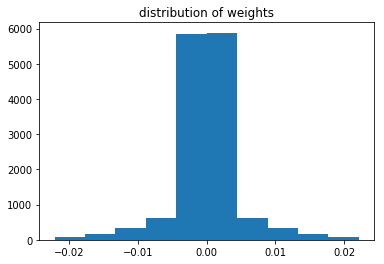

[ 0.0080142   0.00875501  0.0089172   0.00875501  0.0080142   0.00875501
  0.0089172   0.00875501  0.01073338  0.00880857  0.0090544   0.00880857
  0.01073338  0.00880857  0.0090544   0.00880857  0.0080142   0.00875501
  0.0089172   0.00875501  0.0080142   0.00875501  0.0089172   0.00875501
  0.01073338  0.00880857  0.0090544   0.00880857  0.01073338  0.00880857
  0.0090544   0.00880857]


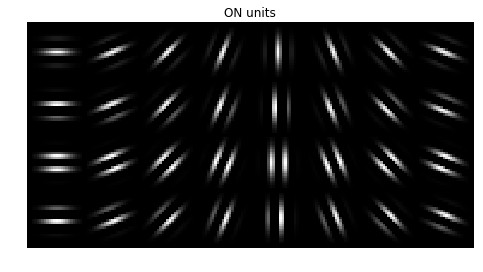

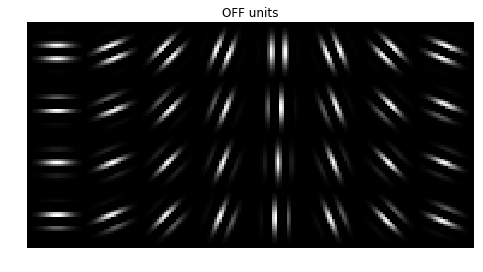

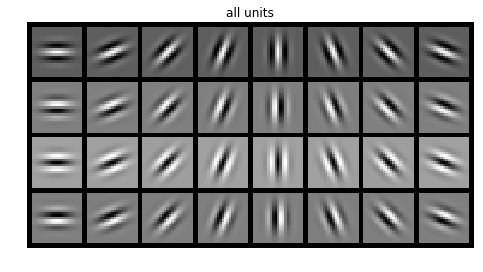

In [7]:
show_filters()

In [8]:
def plot_groups_of_lines(xdata, data, names, style, *, ax=None):
    if ax is None:
        ax = plt.gca()
    assert len(data) == len(names)

    if isinstance(style, str):
        style = [style]*len(data)
    assert len(data) == len(names)

    for idx, (data_this, name_this, style_this) in enumerate(zip(data, names, style)):
        ax.plot(xdata, data_this, label=name_this, linewidth=(idx+1)*2,
                 marker=style_this)
    ax.legend(loc='best')

In [9]:
# fig 5a. basic tuning properties.
# mostly copied from `test_v1_orientation_tuning_contrast` of `/debug/V1_ResponseProperties/test_core.py`
def fig5a():
    grating_wavel = 6
    grating_angles = np.linspace(-22.5, 22.5, 7)
    contrasts = [0.05, 0.2, 0.8]
    patch_diam = 15
    phase = 0
    
    response_all = []
    response_all_init = []
    
    im_all = []
    
    for j, contrast in enumerate(contrasts):
        response_this_contrast = []
        response_this_contrast_init = []
        for i, ga in enumerate(grating_angles):
            #print(j, i)
            im_this = io.image_circular_grating(patch_diam, 20, grating_wavel, ga, phase, contrast)
            im_all.append(im_this.copy())
            im_on, im_off = io.preprocess_image(im_this)

            y_init = core.dim_conv(w_ff_on, w_ff_off, im_on, im_off, iterations=1, verbose=False)
            y_full = core.dim_conv(w_ff_on, w_ff_off, im_on, im_off, iterations=12, verbose=False)
            
            assert y_init.shape == (1, 32, 55, 55)
            assert y_full.shape == (12, 32, 55, 55)
            response_this_contrast.append(y_full[:,0,27,27].mean())
            response_this_contrast_init.append(y_init[0,0,27,27])
        response_all.append(response_this_contrast)
        response_all_init.append(response_this_contrast_init)
    
    # show all the gratings.
    
    imshow_pytorch(make_grid(FloatTensor(np.asarray(im_all)[:,np.newaxis]),
                             nrow=7, normalize=False),
                  title='test images')
    
    # plot
    plt.close('all')
    fig, axes = plt.subplots(1,2,sharex=True, sharey=True, figsize=(20, 10))
    plot_groups_of_lines(grating_angles, np.asarray(response_all),
                         ['low', 'middle', 'high'], 'o', ax=axes[0])
    axes[0].set_title('full response')
    
    plot_groups_of_lines(grating_angles, np.asarray(response_all_init),
                         ['low', 'middle', 'high'], 'o', ax=axes[1])
    axes[1].set_title('init response')
    plt.show()

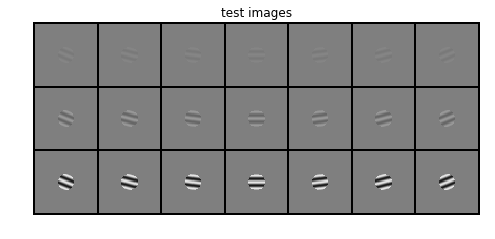

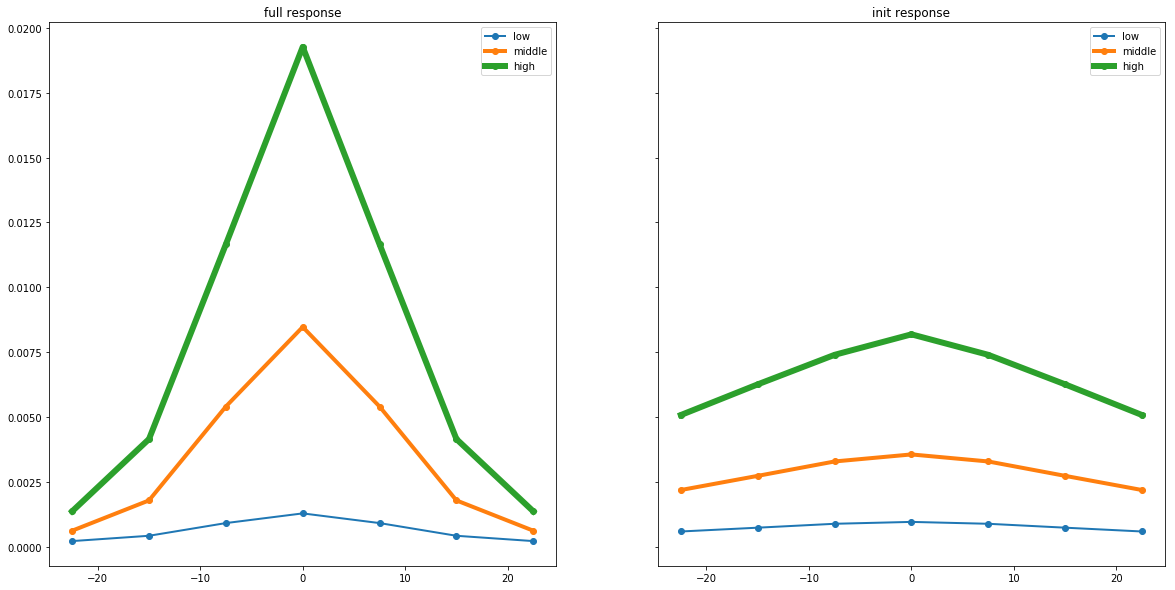

In [10]:
fig5a()

In [11]:
def fig5b():
    grating_wavel = 6
    contrast = 0.25
    diams = np.arange(3, 32, 4)
    phase = 0
    im_all = []
    response_all = []
    response_all_init = []
    for j in range(2):
        response_this_contrast = []
        response_this_contrast_init = []
        for i, diam in enumerate(diams):
            if j == 0:
                im_this = io.image_contextual_surround(diam, diams.max() - diam / 2, 0, grating_wavel, grating_wavel, 0,
                                                       phase, 0, contrast, 0)
            else:
                assert j == 1
                im_this = io.image_contextual_surround(0, diam / 2, diams.max() - diam / 2, grating_wavel,
                                                       grating_wavel, 0, 0, phase, 0, contrast)
            im_all.append(im_this.copy())
            im_on, im_off = io.preprocess_image(im_this)
            y_init = core.dim_conv(w_ff_on, w_ff_off, im_on, im_off, iterations=1, verbose=False)
            y_full = core.dim_conv(w_ff_on, w_ff_off, im_on, im_off, iterations=8, verbose=False)
            assert y_full.shape == (8, 32, 63, 63)
            assert y_init.shape == (1, 32, 63, 63)
            response_this_contrast.append(y_full[:,0,31,31].mean())
            response_this_contrast_init.append(y_init[0,0,31,31])
        response_all.append(response_this_contrast)
        response_all_init.append(response_this_contrast_init)
    
    imshow_pytorch(make_grid(FloatTensor(np.asarray(im_all)[:,np.newaxis]),
                             nrow=8, normalize=False),
                  title='test images')
    
    
    # plot
    plt.close('all')
    fig, axes = plt.subplots(1,2,sharex=True, sharey=True, figsize=(20,10))
    plot_groups_of_lines(diams, np.asarray(response_all),
                         ['disk', 'annular'], ['x', 'o'], ax=axes[0])
    axes[0].set_title('full response')
    plot_groups_of_lines(diams, np.asarray(response_all_init),
                         ['disk', 'annular'], ['x', 'o'], ax=axes[1])
    axes[1].set_title('init response')
    
    plt.show()

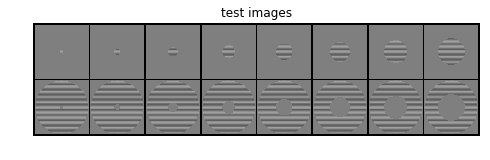

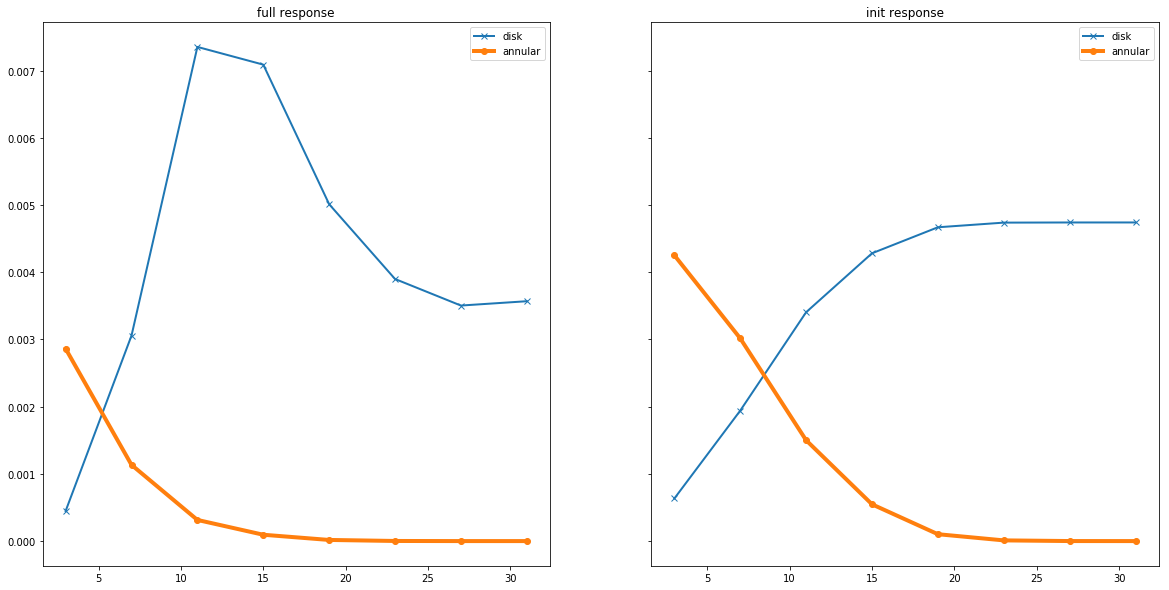

In [12]:
fig5b()
# full response curves are sharper than init ones, as in Figure 5a.